In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from Scipy_anneal import anneal
from sklearn.datasets import make_classification

from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
import math
import time

In [2]:
import warnings; warnings.simplefilter('ignore')

## Applying randomized optimization algorithms to a Multi-layer perceptron

### Cosntruct the MLP class with 1 hidden layer which has following parameters and methods
* Hidden layer size i.e. number of neurons
* Choice of the optimization method for gradient based methods
* Parameter for random weight initialization
* **`Fit()`** method for gradient (Jacobian) and 2nd-derivative (Hessian) based optimization techniques
* **`Fit_simplex()`** method for optimization through simple downhill descent (***derivative-free***)
* **`Fit_anneal()`** method for optimization through simulated annealing (***derivative-free***)
* **`Fit_de()`** method for optimization through differential evolution (from **genetic algorithm** class) (***derivative-free***) 

In [27]:
class NN_1HL(object):

    def __init__(self, epsilon_init=0.12, hidden_layer_size=25, opti_method='TNC'):
        #self.reg_lambda = reg_lambda
        self.epsilon_init = epsilon_init
        self.hidden_layer_size = hidden_layer_size
        self.activation_func = self.sigmoid
        self.activation_func_prime = self.sigmoid_prime
        self.method = opti_method
        #self.maxiter = maxiter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_prime(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)

    def sumsqr(self, a):
        return np.sum(a ** 2)

    def rand_init(self, l_in, l_out):
        self.epsilon_init = (math.sqrt(6))/(math.sqrt(l_in + l_out))
        return np.random.rand(l_out, l_in + 1) * 2 * self.epsilon_init - self.epsilon_init

    def pack_thetas(self, t1, t2):
        return np.concatenate((t1.reshape(-1), t2.reshape(-1)))

    def unpack_thetas(self, thetas, input_layer_size, hidden_layer_size, num_labels):
        t1_start = 0
        t1_end = hidden_layer_size * (input_layer_size + 1)
        t1 = thetas[t1_start:t1_end].reshape((hidden_layer_size, input_layer_size + 1))
        t2 = thetas[t1_end:].reshape((num_labels, hidden_layer_size + 1))
        return t1, t2

    def _forward(self, X, t1, t2):
        m = X.shape[0]
        ones = None
        if len(X.shape) == 1:
            ones = np.array(1).reshape(1,)
        else:
            ones = np.ones(m).reshape(m,1)

        # Input layer
        a1 = np.hstack((ones, X))

        # Hidden Layer
        z2 = np.dot(t1, a1.T)
        a2 = self.activation_func(z2)
        a2 = np.hstack((ones, a2.T))

        # Output layer
        z3 = np.dot(t2, a2.T)
        a3 = self.activation_func(z3)
        return a1, z2, a2, z3, a3

    def function(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        Y = np.eye(num_labels)[y]

        _, _, _, _, h = self._forward(X, t1, t2)
        costPositive = -Y * np.log(h).T
        costNegative = (1 - Y) * np.log(1 - h).T
        cost = costPositive - costNegative
        J = np.sum(cost) / m

        #if reg_lambda != 0:
            #t1f = t1[:, 1:]
            #t2f = t2[:, 1:]
            #reg = (self.reg_lambda / (2 * m)) * (self.sumsqr(t1f) + self.sumsqr(t2f))
            #J = J + reg
        return J

    def function_prime(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        t1f = t1[:, 1:]
        t2f = t2[:, 1:]
        Y = np.eye(num_labels)[y]

        Delta1, Delta2 = 0, 0
        for i, row in enumerate(X):
            a1, z2, a2, z3, a3 = self._forward(row, t1, t2)

            # Backprop
            d3 = a3 - Y[i, :].T
            d2 = np.dot(t2f.T, d3) * self.activation_func_prime(z2)

            Delta2 += np.dot(d3[np.newaxis].T, a2[np.newaxis])
            Delta1 += np.dot(d2[np.newaxis].T, a1[np.newaxis])

        Theta1_grad = (1 / m) * Delta1
        Theta2_grad = (1 / m) * Delta2

        #if reg_lambda != 0:
            #Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (reg_lambda / m) * t1f
            #Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (reg_lambda / m) * t2f

        return self.pack_thetas(Theta1_grad, Theta2_grad)

    def fit_optimize(self, X, y,maxiter=1000):
        """
        Fitting function using scipy.optimize.minimize routines
        Mostly gradient based approaches
        """
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': maxiter}
        _res = optimize.minimize(self.function, thetas0, jac=self.function_prime, method=self.method, 
                                 args=(input_layer_size, self.hidden_layer_size, num_labels, X, y), 
                                 options=options)
        
        #print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_simplex(self, X, y,status=False,maxiter=10000):
        """
        Fits simple hill climbing routine from Scipy.optimize module
        """
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': maxiter}
        _res = optimize.fmin(self.function, thetas0, maxiter=maxiter,disp=status,
                            args=(input_layer_size, self.hidden_layer_size, num_labels, X, y))
        
        #_res=np.array(_res)
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
        return (_res)
        
    def fit_basin_hopping(self, X, y,temp=None,status=False, maxiter=50):
        """
        Fits basin hopping algorithm from Scipy.optimize module
        """
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': maxiter}
        
        if temp!=None:
            model_T=temp
        
        _res = optimize.basinhopping(self.function, thetas0, niter=maxiter,T=model_T,disp=status,
                                    minimizer_kwargs={'args':(input_layer_size, self.hidden_layer_size, 
                                                              num_labels, X, y),'method':'Nelder-Mead'})
        
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
    
    def fit_anneal(self, X, y,status=False, maxiter=50,T0=None,Tf=1e-12,bound=10,
                   learn_rate=0.1,schedule='fast',quench=0.1):
        """
        Fits a simulated annealing type algorithm from Scipy.optimize module (Scipy 13.0)
        """
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': maxiter}
                       
        _res = anneal(self.function, thetas0, maxiter=maxiter,disp=status, T0=T0, Tf=Tf,full_output=1,
                      learn_rate=learn_rate,lower=-bound,upper=bound,schedule=schedule,
                       args=(input_layer_size, self.hidden_layer_size, num_labels, X, y))
        
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res[0], input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
        return (_res)
        
    def fit_de(self, X, y,bound=10,status=False,strategy='best1bin',popsize=10,mutation=(0.5,1.0),
              recombination=0.7,init='latinhypercube',maxiter=100):
        """
        Fits a differential evolution algorithm (a variant of Genetic Algorithm)
        bound: Bounds for variables
        """
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        #options = {'maxiter': maxiter}
        
        _res = optimize.differential_evolution(self.function, bounds=[(-bound,bound)]*len(thetas0), 
                                               maxiter=maxiter, disp=status,
                                    args=(input_layer_size, self.hidden_layer_size,num_labels, X, y, 0))
        
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")

    def predict(self, X):
        return self.predict_proba(X).argmax(0)

    def predict_proba(self, X):
        _, _, _, _, h = self._forward(X, self.t1, self.t2)
        return h

### For test - create some synthetic data

In [4]:
data = make_classification(n_samples=2000,n_features=10,n_informative=8,
                           n_classes=2,n_redundant=2,class_sep=0.5,flip_y=0.1,random_state=101)

In [5]:
features=data[0]
response=data[1]
full_data=np.column_stack((features,response))

In [6]:
df=pd.DataFrame(full_data,columns=['X'+str(i) for i in range(10)]+['y'])

In [7]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,y
0,1.003426,-2.312380,0.318618,6.073289,3.155619,-1.242528,3.512543,3.100110,-2.796763,-0.909995,1.0
1,-1.636250,-3.344617,-3.444260,2.343867,-0.387346,1.909461,2.755389,-0.058569,1.510011,-1.796563,0.0
2,2.507000,-1.860780,-1.146980,-0.133214,0.677580,1.821212,2.230431,0.020075,-0.156822,1.313318,0.0
3,-0.647876,0.666496,-1.818128,1.648000,0.155004,1.388657,-1.425870,1.056784,2.652186,-1.503872,1.0
4,-1.915191,1.401883,0.297260,1.857918,0.907377,0.144483,-0.700599,-1.091122,2.420557,-2.813451,0.0


### Visualize

We plot histograms, boxlots and scatterplots of the dataset and observe that the **class separation is not very obvious**. Particularly, boxplots show lot of overlap between features for two output classes.

So, this should be a **non-trivial classification task.**

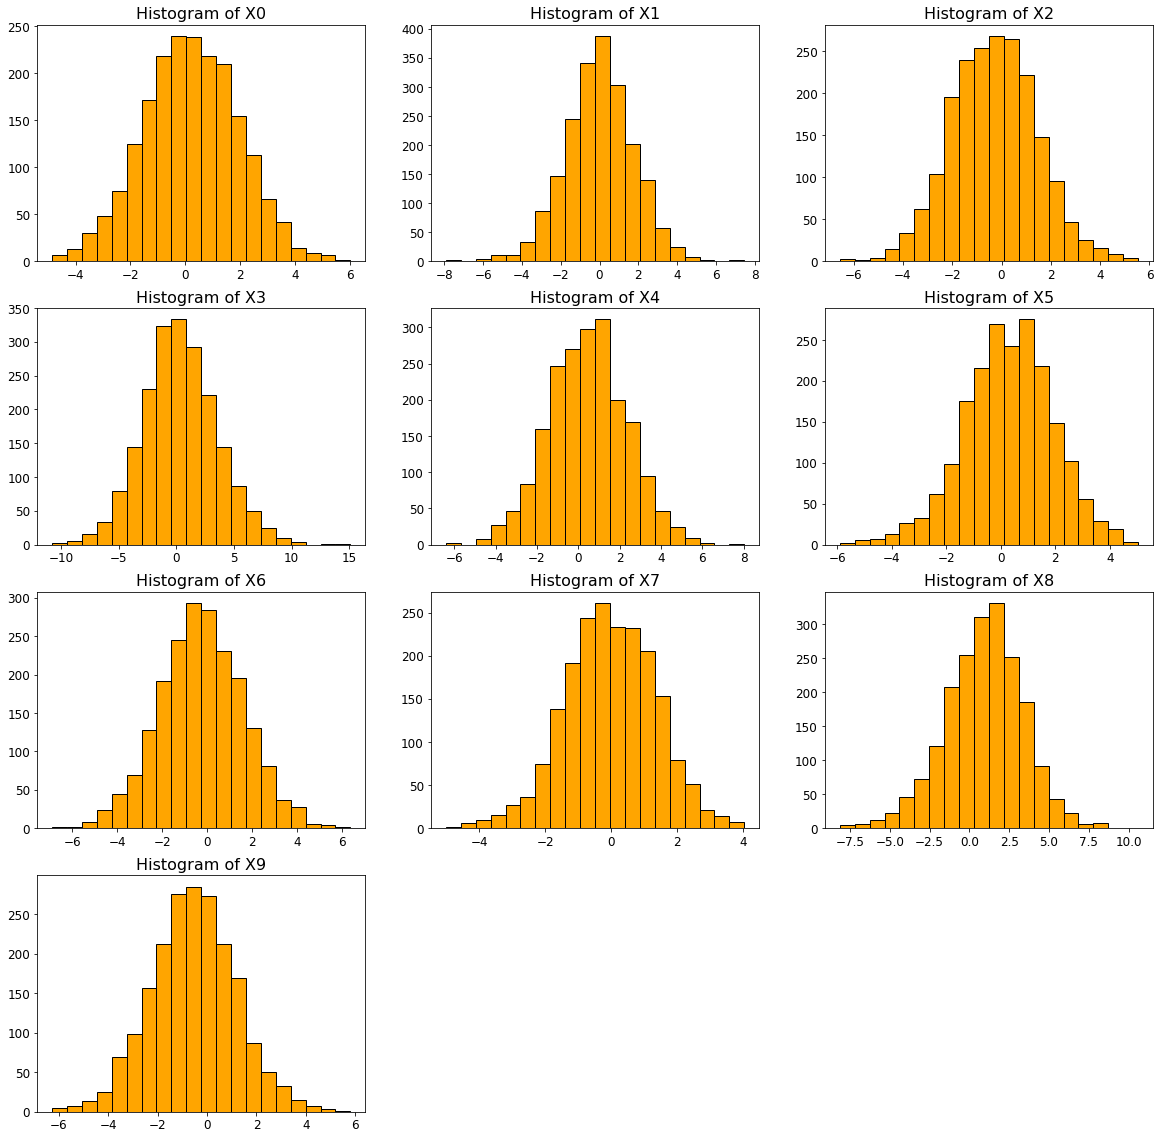

In [10]:
i=1
plt.figure(figsize=(20,20))
for c in df.describe().columns[:-1]:
    plt.subplot(4,3,i)
    plt.title(f"Histogram of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.hist(df[c],bins=20,color='orange',edgecolor='k')
    i+=1
plt.show()

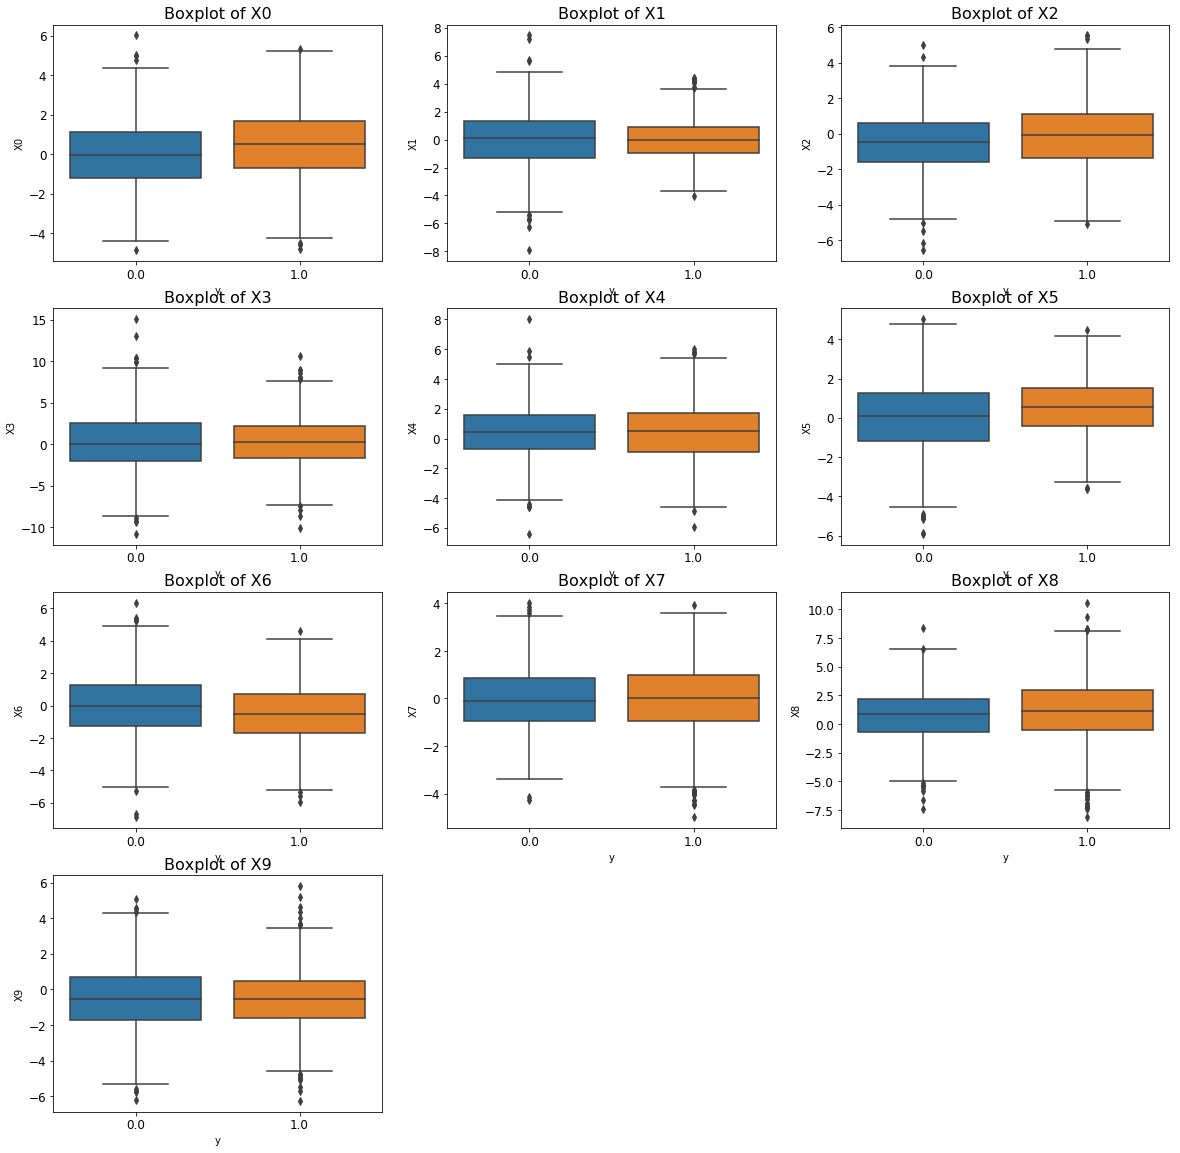

In [11]:
i=1
plt.figure(figsize=(20,20))
for c in df.columns[:-1]:
    plt.subplot(4,3,i)
    plt.title(f"Boxplot of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.boxplot(y=df[c],x=df['y'])
    i+=1
plt.show()

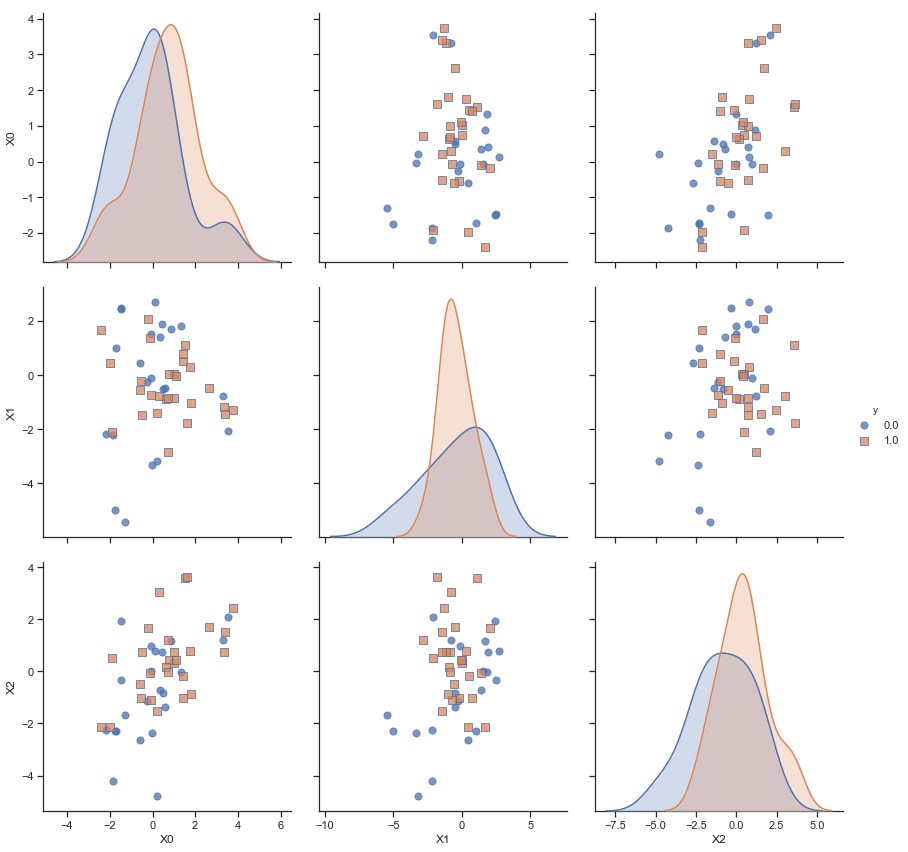

In [12]:
df_sample=df.sample(n=50)
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(df_sample,vars=['X0','X1','X2'],
               plot_kws=dict(s=50, edgecolor="b", linewidth=1,alpha=0.75),
               hue="y",markers=["o", "s"], diag_kind="kde",diag_kws=dict(shade=True), size=4)

### Save the data in a text file

In [10]:
np.savetxt('scipy_test.txt',X=full_data,delimiter=', ')

### Read the data from the file

In [11]:
values = np.loadtxt('scipy_test.txt', delimiter=', ', usecols=[i for i in range(10)])
targets = np.loadtxt('scipy_test.txt', delimiter=', ', dtype=(int), usecols=[10])

### Standard scaling and min/max scaling

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [13]:
sc=StandardScaler()
mms = MinMaxScaler()

In [14]:
values_scaled=sc.fit_transform(values)
values_minmax=mms.fit_transform(values)

### Train/test split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(values, targets, test_size=0.3,random_state=101)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,random_state=101)

In [21]:
#X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = cross_validation.train_test_split(values_scaled, targets, test_size=0.4)

In [22]:
#X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = cross_validation.train_test_split(values_minmax, targets, test_size=0.4)

## With <span style=color:blue>simple hill climb (descent)</span> algorithm

In [18]:
nn = NN_1HL(hidden_layer_size=5)
_res=nn.fit_simplex(X_train, y_train,maxiter=1000)
print("Accuracy of classification: "+str(accuracy_score(y_val, nn.predict(X_val))))
print("F1 score of classification: "+str(f1_score(y_val, nn.predict(X_val))))

Accuracy of classification: 0.5666666666666667
F1 score of classification: 0.6153846153846154


### Random restart with 1000 iterations max

In [22]:
random_restart_accuracy=[]
random_restart_f1=[]

n_restart=25
nn = NN_1HL(hidden_layer_size=5)
for i in range(n_restart):
    nn.fit_simplex(X_train, y_train,maxiter=1000)
    random_restart_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    random_restart_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for: ",i+1)

Done for:  1
Done for:  2
Done for:  3
Done for:  4
Done for:  5
Done for:  6
Done for:  7
Done for:  8
Done for:  9
Done for:  10
Done for:  11
Done for:  12
Done for:  13
Done for:  14
Done for:  15
Done for:  16
Done for:  17
Done for:  18
Done for:  19
Done for:  20
Done for:  21
Done for:  22
Done for:  23
Done for:  24
Done for:  25


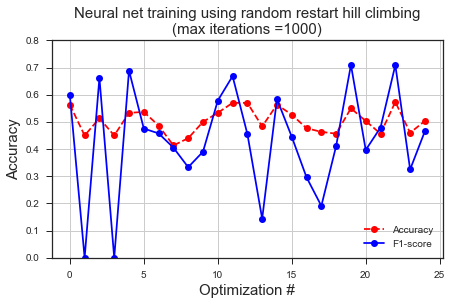

In [23]:
plt.figure(figsize=(7,4))
plt.title("Neural net training using random restart hill climbing\n(max iterations =1000)",fontsize=15)
plt.plot(random_restart_accuracy,'bo',ls='--',c='red')
plt.plot(random_restart_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i for i in range(0,26,5)])
plt.xlabel("Optimization #",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.legend(['Accuracy','F1-score'])
plt.ylim(0,0.8)
plt.show()

### Random restart with 5000 iterations max

In [24]:
random_restart_accuracy=[]
random_restart_f1=[]

n_restart=25
nn = NN_1HL(hidden_layer_size=5)
for i in range(n_restart):
    nn.fit_simplex(X_train, y_train,maxiter=5000)
    random_restart_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    random_restart_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for: ",i+1)

Done for:  1
Done for:  2
Done for:  3
Done for:  4
Done for:  5
Done for:  6
Done for:  7
Done for:  8
Done for:  9
Done for:  10
Done for:  11
Done for:  12
Done for:  13
Done for:  14
Done for:  15
Done for:  16
Done for:  17
Done for:  18
Done for:  19
Done for:  20
Done for:  21
Done for:  22
Done for:  23
Done for:  24
Done for:  25


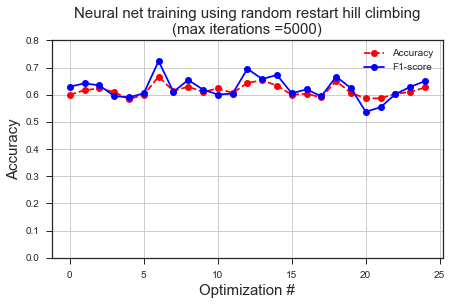

In [25]:
plt.figure(figsize=(7,4))
plt.title("Neural net training using random restart hill climbing\n(max iterations =5000)",fontsize=15)
plt.plot(random_restart_accuracy,'bo',ls='--',c='red')
plt.plot(random_restart_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i for i in range(0,26,5)])
plt.xlabel("Optimization #",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.legend(['Accuracy','F1-score'])
plt.ylim(0,0.8)
plt.show()

### How number of max iterations impact performance 

In [26]:
iteration_accuracy=[]
iteration_f1=[]
iteration_time=[]
iterations=[250*i for i in range(1,31)]
nn = NN_1HL(hidden_layer_size=5)

for i in iterations:
    t1=time.time()
    nn.fit_simplex(X_train, y_train,maxiter=i)
    t2=time.time()
    iteration_time.append(t2-t1)
    iteration_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    iteration_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for iterations: ",i)

Done for iterations:  250
Done for iterations:  500
Done for iterations:  750
Done for iterations:  1000
Done for iterations:  1250
Done for iterations:  1500
Done for iterations:  1750
Done for iterations:  2000
Done for iterations:  2250
Done for iterations:  2500
Done for iterations:  2750
Done for iterations:  3000
Done for iterations:  3250
Done for iterations:  3500
Done for iterations:  3750
Done for iterations:  4000
Done for iterations:  4250
Done for iterations:  4500
Done for iterations:  4750
Done for iterations:  5000
Done for iterations:  5250
Done for iterations:  5500
Done for iterations:  5750
Done for iterations:  6000
Done for iterations:  6250
Done for iterations:  6500
Done for iterations:  6750
Done for iterations:  7000
Done for iterations:  7250
Done for iterations:  7500


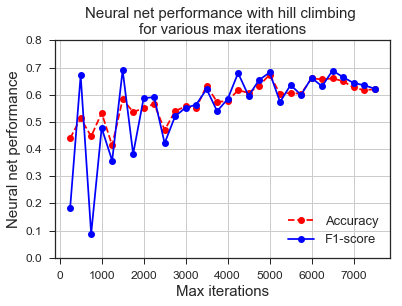

In [29]:
plt.figure(figsize=(6,4))
plt.title("Neural net performance with hill climbing \nfor various max iterations",fontsize=15)
plt.plot(iterations,iteration_accuracy,'bo',ls='--',c='red')
plt.plot(iterations,iteration_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Max iterations",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.0,0.8)
plt.show()

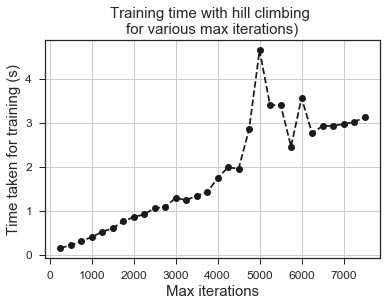

In [31]:
plt.figure(figsize=(6,4))
plt.title("Training time with hill climbing \nfor various max iterations)",fontsize=15)
plt.plot(iterations,iteration_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Max iterations",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
#plt.ylim(0.4,0.8)
plt.show()

## With <span style=color:blue>simulated annealing</span> algorithm

In [121]:
nn = NN_1HL(hidden_layer_size=5)
res=nn.fit_anneal(X_train, y_train,status=False,maxiter=300,T0=1,learn_rate=0.2,schedule='fast')
print("Accuracy of classification: "+str(accuracy_score(y_val, nn.predict(X_val))))
print("F1 score of classification: "+str(f1_score(y_val, nn.predict(X_val))))
#print(res)

Accuracy of classification: 0.45
F1 score of classification: 0.0


### Impact of number of iteraions

In [122]:
iteration_accuracy=[]
iteration_f1=[]
iteration_time=[]
iterations=[50*i for i in range(1,102,5)]
nn = NN_1HL(hidden_layer_size=5)

for i in iterations:
    t1=time.time()
    res=nn.fit_anneal(X_train, y_train,status=False,maxiter=i,T0=1,learn_rate=1.0,schedule='fast',bound=1)
    t2=time.time()
    iteration_time.append(t2-t1)
    iteration_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    iteration_f1.append(f1_score(y_val, nn.predict(X_val)))
    print(f"Done for iterations: {i}. Reason for termination, {res[6]}")

Done for iterations: 50. Reason for termination, 0
Done for iterations: 300. Reason for termination, 1
Done for iterations: 550. Reason for termination, 0
Done for iterations: 800. Reason for termination, 1
Done for iterations: 1050. Reason for termination, 1
Done for iterations: 1300. Reason for termination, 0
Done for iterations: 1550. Reason for termination, 0
Done for iterations: 1800. Reason for termination, 0
Done for iterations: 2050. Reason for termination, 1
Done for iterations: 2300. Reason for termination, 5
Done for iterations: 2550. Reason for termination, 1
Done for iterations: 2800. Reason for termination, 1
Done for iterations: 3050. Reason for termination, 0
Done for iterations: 3300. Reason for termination, 5
Done for iterations: 3550. Reason for termination, 1
Done for iterations: 3800. Reason for termination, 0
Done for iterations: 4050. Reason for termination, 5
Done for iterations: 4300. Reason for termination, 1
Done for iterations: 4550. Reason for termination, 

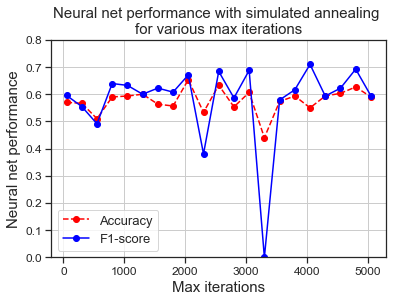

In [123]:
plt.figure(figsize=(6,4))
plt.title("Neural net performance with simulated annealing \nfor various max iterations",fontsize=15)
plt.plot(iterations,iteration_accuracy,'bo',ls='--',c='red')
plt.plot(iterations,iteration_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Max iterations",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.0,0.8)
plt.show()

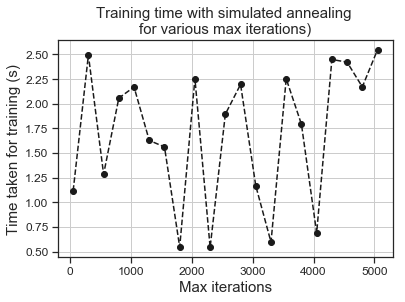

In [124]:
plt.figure(figsize=(6,4))
plt.title("Training time with simulated annealing \nfor various max iterations)",fontsize=15)
plt.plot(iterations,iteration_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Max iterations",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
#plt.ylim(0.4,0.8)
plt.show()

### Impact of starting temperature

In [118]:
temp_accuracy=[]
temp_f1=[]
temp_time=[]
temps=[2**(0.5*i) for i in range(-5,16,1)]
nn = NN_1HL(hidden_layer_size=5)

for t in temps:
    t1=time.time()
    res=nn.fit_anneal(X_train, y_train,status=False,maxiter=500,T0=t,learn_rate=1.0,schedule='fast',bound=1)
    t2=time.time()
    temp_time.append(t2-t1)
    temp_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    temp_f1.append(f1_score(y_val, nn.predict(X_val)))
    print(f"Done for starting temp: {t}. Reason for termination, {res[6]}")

Done for starting temp: 0.1767766952966369. Reason for termination, 1
Done for starting temp: 0.25. Reason for termination, 1
Done for starting temp: 0.3535533905932738. Reason for termination, 0
Done for starting temp: 0.5. Reason for termination, 1
Done for starting temp: 0.7071067811865476. Reason for termination, 0
Done for starting temp: 1.0. Reason for termination, 0
Done for starting temp: 1.4142135623730951. Reason for termination, 0
Done for starting temp: 2.0. Reason for termination, 0
Done for starting temp: 2.8284271247461903. Reason for termination, 0
Done for starting temp: 4.0. Reason for termination, 0
Done for starting temp: 5.656854249492381. Reason for termination, 0
Done for starting temp: 8.0. Reason for termination, 0
Done for starting temp: 11.313708498984761. Reason for termination, 0
Done for starting temp: 16.0. Reason for termination, 1
Done for starting temp: 22.627416997969522. Reason for termination, 1
Done for starting temp: 32.0. Reason for termination, 

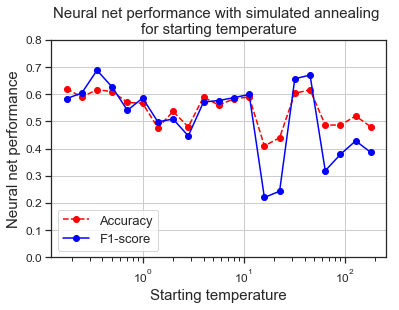

In [119]:
plt.figure(figsize=(6,4))
plt.title("Neural net performance with simulated annealing \nfor starting temperature",fontsize=15)
plt.semilogx(temps,temp_accuracy,'bo',ls='--',c='red')
plt.plot(temps,temp_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Starting temperature",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.0,0.8)
plt.show()

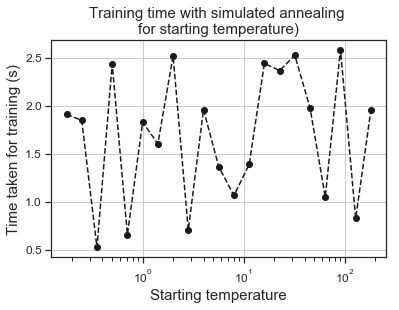

In [125]:
plt.figure(figsize=(6,4))
plt.title("Training time with simulated annealing \nfor starting temperature)",fontsize=15)
plt.semilogx(temps,temp_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Starting temperature",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
#plt.ylim(0.4,0.8)
plt.show()

### Impact of larning rate (scale constant for tuning the probabilistc acceptance criteria)

In [131]:
learn_accuracy=[]
learn_f1=[]
learn_time=[]
learns=[2**(0.5*i) for i in range(-11,11,1)]
nn = NN_1HL(hidden_layer_size=5)

for l in learns:
    t1=time.time()
    res=nn.fit_anneal(X_train, y_train,status=False,maxiter=500,T0=10,learn_rate=l,schedule='fast',bound=1)
    t2=time.time()
    learn_time.append(t2-t1)
    learn_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    learn_f1.append(f1_score(y_val, nn.predict(X_val)))
    print(f"Done for learning rate: {l}. Reason for termination, {res[6]}")

Done for learning rate: 0.02209708691207961. Reason for termination, 1
Done for learning rate: 0.03125. Reason for termination, 0
Done for learning rate: 0.04419417382415922. Reason for termination, 0
Done for learning rate: 0.0625. Reason for termination, 1
Done for learning rate: 0.08838834764831845. Reason for termination, 0
Done for learning rate: 0.125. Reason for termination, 1
Done for learning rate: 0.1767766952966369. Reason for termination, 0
Done for learning rate: 0.25. Reason for termination, 1
Done for learning rate: 0.3535533905932738. Reason for termination, 0
Done for learning rate: 0.5. Reason for termination, 1
Done for learning rate: 0.7071067811865476. Reason for termination, 1
Done for learning rate: 1.0. Reason for termination, 0
Done for learning rate: 1.4142135623730951. Reason for termination, 1
Done for learning rate: 2.0. Reason for termination, 1
Done for learning rate: 2.8284271247461903. Reason for termination, 0
Done for learning rate: 4.0. Reason for te

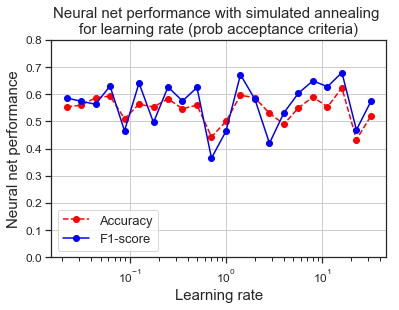

In [134]:
plt.figure(figsize=(6,4))
plt.title("Neural net performance with simulated annealing \nfor learning rate (prob acceptance criteria)",fontsize=15)
plt.semilogx(learns,learn_accuracy,'bo',ls='--',c='red')
plt.semilogx(learns,learn_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Learning rate",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.0,0.8)
plt.show()

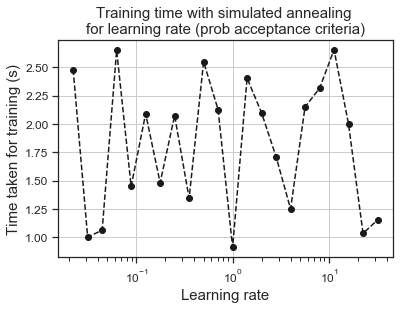

In [137]:
plt.figure(figsize=(6,4))
plt.title("Training time with simulated annealing \nfor learning rate (prob acceptance criteria)",fontsize=15)
plt.semilogx(learns,learn_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Learning rate",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
#plt.ylim(0.4,0.8)
plt.show()

## Fit with <span style=color:blue>differential evolution</span> algorithm and show accuracy and F1 score

In [53]:
nn = NN_1HL(hidden_layer_size=5)
nn.fit_de(X_train, y_train,bound=0.5,status=True,maxiter=10,popsize=2,mutation=1.0)
print("Accuracy of classification: "+str(accuracy_score(y_val, nn.predict(X_val))))
print("F1 score of classification: "+str(f1_score(y_val, nn.predict(X_val))))

differential_evolution step 1: f(x)= 1.36411
differential_evolution step 2: f(x)= 1.36411
differential_evolution step 3: f(x)= 1.36115
differential_evolution step 4: f(x)= 1.36115
     fun: 1.2682586870279913
     jac: array([ 5.99142957e-03,  5.49975621e-03, -8.43769499e-07,  3.01636494e-03,
        4.71733763e-04,  2.44249065e-07,  2.07875939e-03,  8.39328607e-06,
        1.75486292e-03,  4.62467842e-03, -4.98263653e-03,  2.43203235e-03,
       -3.44331230e-03, -5.51181323e-04, -8.54871729e-06, -1.70974346e-06,
       -3.59712260e-06, -6.19504448e-06, -7.30702165e-03, -5.70188341e-04,
        4.35207426e-06,  2.73785439e-03, -5.73072700e-03, -6.15509865e-03,
       -1.60089719e-03, -3.94682065e-03, -3.77475828e-07,  2.46469511e-06,
       -1.45856660e-03, -8.04400990e-04, -1.93429717e-03, -3.66333630e-03,
        4.62507810e-03,  3.52113894e-03, -4.79758455e-03,  8.26760882e-04,
       -2.08300044e-03, -1.39888101e-06, -1.50810475e-03, -6.13731288e-05,
        1.37667655e-06, -1.7157

### Impact of population size

In [64]:
population_accuracy=[]
population_f1=[]
population_time=[]

n_population=20
nn = NN_1HL(hidden_layer_size=5)
for p in range(1,n_population+1):
    t1=time.time()
    nn.fit_de(X_train, y_train,bound=0.5,status=False,maxiter=10,popsize=i,mutation=1.0)
    t2=time.time()
    population_time.append(t2-t1)
    population_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    population_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for: ",p)

Done for:  1
Done for:  2
Done for:  3
Done for:  4
Done for:  5
Done for:  6
Done for:  7
Done for:  8
Done for:  9
Done for:  10
Done for:  11
Done for:  12
Done for:  13
Done for:  14
Done for:  15
Done for:  16
Done for:  17
Done for:  18
Done for:  19
Done for:  20


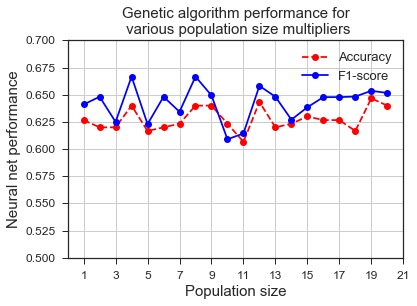

In [65]:
plt.figure(figsize=(6,4))
plt.title("Genetic algorithm performance for\n various population size multipliers",fontsize=15)
plt.plot([i for i in range(1,21)],population_accuracy,'bo',ls='--',c='red')
plt.plot([i for i in range(1,21)],population_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Population size",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.5,0.7)
plt.show()

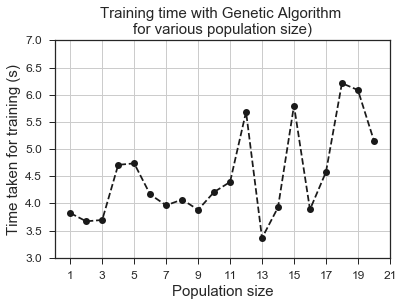

In [68]:
plt.figure(figsize=(6,4))
plt.title("Training time with Genetic Algorithm \nfor various population size)",fontsize=15)
plt.plot([i for i in range(1,21)],population_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks([i for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Population size",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
plt.ylim(3,7)
plt.show()

### Impact of mutation rate

In [69]:
mutation_accuracy=[]
mutation_f1=[]
mutation_time=[]

mutations=[i*0.1 for i in range(1,21)]
nn = NN_1HL(hidden_layer_size=5)
for m in mutations:
    t1=time.time()
    nn.fit_de(X_train, y_train,bound=0.5,status=False,maxiter=10,popsize=5,mutation=m)
    t2=time.time()
    mutation_time.append(t2-t1)
    mutation_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    mutation_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for mutation: ",m)

Done for mutation:  0.1
Done for mutation:  0.2
Done for mutation:  0.30000000000000004
Done for mutation:  0.4
Done for mutation:  0.5
Done for mutation:  0.6000000000000001
Done for mutation:  0.7000000000000001
Done for mutation:  0.8
Done for mutation:  0.9
Done for mutation:  1.0
Done for mutation:  1.1
Done for mutation:  1.2000000000000002
Done for mutation:  1.3
Done for mutation:  1.4000000000000001
Done for mutation:  1.5
Done for mutation:  1.6
Done for mutation:  1.7000000000000002
Done for mutation:  1.8
Done for mutation:  1.9000000000000001
Done for mutation:  2.0


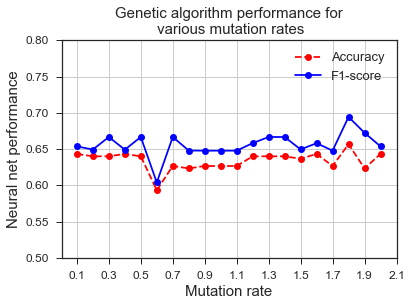

In [77]:
plt.figure(figsize=(6,4))
plt.title("Genetic algorithm performance for\n various mutation rates",fontsize=15)
plt.plot(mutations,mutation_accuracy,'bo',ls='--',c='red')
plt.plot(mutations,mutation_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i*0.1 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Mutation rate",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.5,0.8)
plt.show()

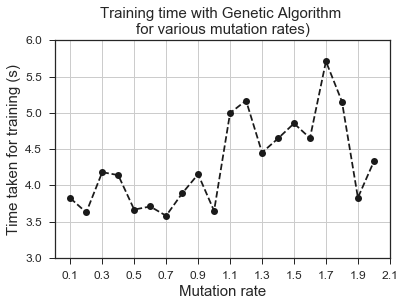

In [79]:
plt.figure(figsize=(6,4))
plt.title("Training time with Genetic Algorithm \nfor various mutation rates)",fontsize=15)
plt.plot(mutations,mutation_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks([i*0.1 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Mutation rate",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
plt.ylim(3,6)
plt.show()

In [80]:
mutation_accuracy=[]
mutation_f1=[]
mutation_time=[]

mutations=[i*0.1 for i in range(1,21)]
nn = NN_1HL(hidden_layer_size=5)
for m in mutations:
    t1=time.time()
    nn.fit_de(X_train, y_train,bound=5,status=False,maxiter=10,popsize=5,mutation=m)
    t2=time.time()
    mutation_time.append(t2-t1)
    mutation_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    mutation_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for mutation: ",m)

Done for mutation:  0.1
Done for mutation:  0.2
Done for mutation:  0.30000000000000004
Done for mutation:  0.4
Done for mutation:  0.5
Done for mutation:  0.6000000000000001
Done for mutation:  0.7000000000000001
Done for mutation:  0.8
Done for mutation:  0.9
Done for mutation:  1.0
Done for mutation:  1.1
Done for mutation:  1.2000000000000002
Done for mutation:  1.3
Done for mutation:  1.4000000000000001
Done for mutation:  1.5
Done for mutation:  1.6
Done for mutation:  1.7000000000000002
Done for mutation:  1.8
Done for mutation:  1.9000000000000001
Done for mutation:  2.0


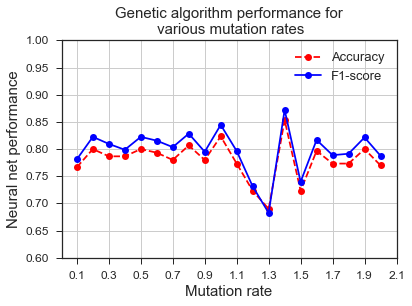

In [82]:
plt.figure(figsize=(6,4))
plt.title("Genetic algorithm performance for\n various mutation rates",fontsize=15)
plt.plot(mutations,mutation_accuracy,'bo',ls='--',c='red')
plt.plot(mutations,mutation_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i*0.1 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Mutation rate",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.6,1.0)
plt.show()

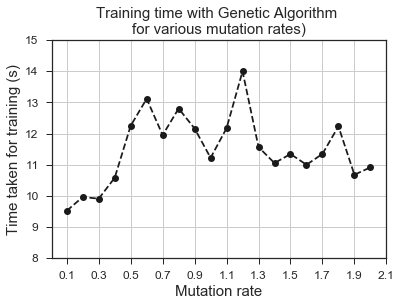

In [85]:
plt.figure(figsize=(6,4))
plt.title("Training time with Genetic Algorithm \nfor various mutation rates)",fontsize=15)
plt.plot(mutations,mutation_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks([i*0.1 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Mutation rate",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
plt.ylim(8,15)
plt.show()

### Impact of cross-over

In [93]:
crossover_accuracy=[]
crossover_f1=[]
crossover_time=[]

crossovers=[i*0.05 for i in range(1,21)]
nn = NN_1HL(hidden_layer_size=5)
for c in crossovers:
    t1=time.time()
    nn.fit_de(X_train, y_train,bound=5,status=False,maxiter=10,popsize=5,mutation=1.0,recombination=c)
    t2=time.time()
    crossover_time.append(t2-t1)
    crossover_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    crossover_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for crossover: ",c)

Done for crossover:  0.05
Done for crossover:  0.1
Done for crossover:  0.15000000000000002
Done for crossover:  0.2
Done for crossover:  0.25
Done for crossover:  0.30000000000000004
Done for crossover:  0.35000000000000003
Done for crossover:  0.4
Done for crossover:  0.45
Done for crossover:  0.5
Done for crossover:  0.55
Done for crossover:  0.6000000000000001
Done for crossover:  0.65
Done for crossover:  0.7000000000000001
Done for crossover:  0.75
Done for crossover:  0.8
Done for crossover:  0.8500000000000001
Done for crossover:  0.9
Done for crossover:  0.9500000000000001
Done for crossover:  1.0


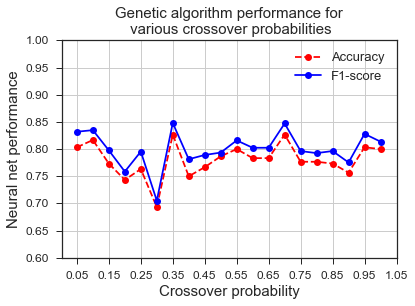

In [94]:
plt.figure(figsize=(6,4))
plt.title("Genetic algorithm performance for\n various crossover probabilities",fontsize=15)
plt.plot(crossovers,crossover_accuracy,'bo',ls='--',c='red')
plt.plot(crossovers,crossover_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i*0.05 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Crossover probability",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.6,1.0)
plt.show()

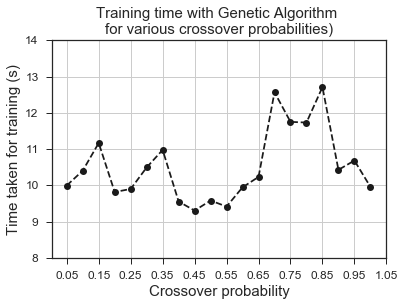

In [96]:
plt.figure(figsize=(6,4))
plt.title("Training time with Genetic Algorithm \nfor various crossover probabilities)",fontsize=15)
plt.plot(crossovers,crossover_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks([i*0.05 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Crossover probability",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
plt.ylim(8,14)
plt.show()

### Impact of search bound used in GA

In [97]:
bound_accuracy=[]
bound_f1=[]
bound_time=[]

bounds=[i*0.25 for i in range(1,21)]
nn = NN_1HL(hidden_layer_size=5)
for b in bounds:
    t1=time.time()
    nn.fit_de(X_train, y_train,bound=b,status=False,maxiter=10,popsize=5,mutation=1.0,recombination=0.5)
    t2=time.time()
    bound_time.append(t2-t1)
    bound_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    bound_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for bound: ",b)

Done for bound:  0.25
Done for bound:  0.5
Done for bound:  0.75
Done for bound:  1.0
Done for bound:  1.25
Done for bound:  1.5
Done for bound:  1.75
Done for bound:  2.0
Done for bound:  2.25
Done for bound:  2.5
Done for bound:  2.75
Done for bound:  3.0
Done for bound:  3.25
Done for bound:  3.5
Done for bound:  3.75
Done for bound:  4.0
Done for bound:  4.25
Done for bound:  4.5
Done for bound:  4.75
Done for bound:  5.0


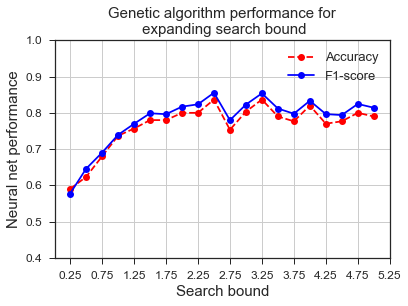

In [99]:
plt.figure(figsize=(6,4))
plt.title("Genetic algorithm performance for\n expanding search bound",fontsize=15)
plt.plot(bounds,bound_accuracy,'bo',ls='--',c='red')
plt.plot(bounds,bound_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i*0.25 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Search bound",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.4,1.0)
plt.show()

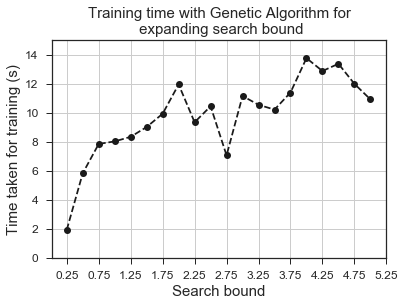

In [102]:
plt.figure(figsize=(6,4))
plt.title("Training time with Genetic Algorithm for\n expanding search bound",fontsize=15)
plt.plot(bounds,bound_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks([i*0.25 for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Search bound",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
plt.ylim(0,15)
plt.show()

### Impact of iterations

In [104]:
generation_accuracy=[]
generation_f1=[]
generation_time=[]

generations=[i for i in range(1,21)]
nn = NN_1HL(hidden_layer_size=5)
for g in generations:
    t1=time.time()
    nn.fit_de(X_train, y_train,bound=5,status=False,maxiter=g,popsize=5,mutation=1.0,recombination=0.5)
    t2=time.time()
    generation_time.append(t2-t1)
    generation_accuracy.append(accuracy_score(y_val, nn.predict(X_val)))
    generation_f1.append(f1_score(y_val, nn.predict(X_val)))
    print("Done for generation: ",g)

Done for generation:  1
Done for generation:  2
Done for generation:  3
Done for generation:  4
Done for generation:  5
Done for generation:  6
Done for generation:  7
Done for generation:  8
Done for generation:  9
Done for generation:  10
Done for generation:  11
Done for generation:  12
Done for generation:  13
Done for generation:  14
Done for generation:  15
Done for generation:  16
Done for generation:  17
Done for generation:  18
Done for generation:  19
Done for generation:  20


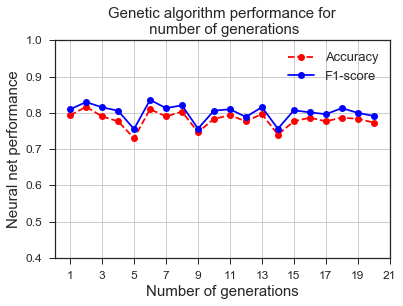

In [105]:
plt.figure(figsize=(6,4))
plt.title("Genetic algorithm performance for\n number of generations",fontsize=15)
plt.plot(generations,generation_accuracy,'bo',ls='--',c='red')
plt.plot(generations,generation_f1,'bo',ls='-',c='blue')
plt.grid(True)
plt.xticks([i for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Number of generations",fontsize=15)
plt.ylabel("Neural net performance",fontsize=15)
plt.legend(['Accuracy','F1-score'],fontsize=13)
plt.ylim(0.4,1.0)
plt.show()

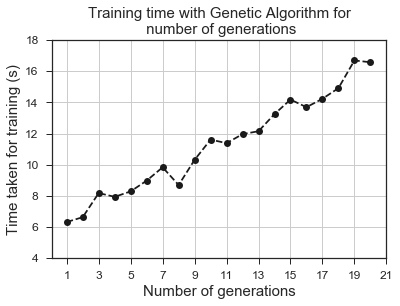

In [109]:
plt.figure(figsize=(6,4))
plt.title("Training time with Genetic Algorithm for\n number of generations",fontsize=15)
plt.plot(generations,generation_time,'bo',ls='--',c='k')
plt.grid(True)
plt.xticks([i for i in range(1,22,2)],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Number of generations",fontsize=15)
plt.ylabel("Time taken for training (s)",fontsize=15)
plt.ylim(4,18)
plt.show()

## Try various optimization rotuines, which use gradient information, from `scipy.optimize()`

In [20]:
solvers=['BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

In [29]:
for s in solvers:
    nn = NN_1HL(opti_method=s,hidden_layer_size=5)
    nn.fit_optimize(X_train, y_train,maxiter=1000)
    print(f"Accuracy of classification: using {s}: "+str(accuracy_score(y_val, nn.predict(X_val))))
    print(f"F1-score of classification: using {s}: "+str(f1_score(y_val, nn.predict(X_val))))
    print("="*80)

Accuracy of classification: using BFGS: 0.82
F1-score of classification: using BFGS: 0.8392857142857144
Accuracy of classification: using L-BFGS-B: 0.8166666666666667
F1-score of classification: using L-BFGS-B: 0.8338368580060422
Accuracy of classification: using TNC: 0.7833333333333333
F1-score of classification: using TNC: 0.7975077881619939
Accuracy of classification: using COBYLA: 0.6633333333333333
F1-score of classification: using COBYLA: 0.6892307692307692
Accuracy of classification: using SLSQP: 0.74
F1-score of classification: using SLSQP: 0.7364864864864865


## Deep neural net (using `keras`)

In [30]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [36]:
n_input=X_train.shape[0]
num_classes = 2
input_dim=X_train.shape[1]

### Function to construct 2-hidden-layer Keras model

In [37]:
def make_2layer_NN(input_dim, num_classes, neuron_layer_1=5, neuron_layer_2=5, dropout_prob=0.25, \
                  activation_func='relu', learning_rate=0.01,optimizer='SGD'):
    """
    Creates a 2-hidden-layer Keras Neural Network model by adding densely connected layers, \
    dropout layers, and an output layer with 'softmax' activation with appropriate number of nodes for classification
    """
    model = Sequential()
    model.add(Dense(neuron_layer_1, input_shape=(input_dim,),activation=activation_func))
    model.add(Dropout(dropout_prob))
    model.add(Dense(neuron_layer_2,activation=activation_func))
    model.add(Dropout(dropout_prob))
    # Softmax activation for the last layer for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    if optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate)
    if optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

### Function to construct 1-hidden-layer Keras model

In [38]:
def make_1layer_NN(input_dim, num_classes, neuron_layer_1=5, dropout_prob=0.25, \
                  activation_func='relu', learning_rate=0.01,optimizer='SGD'):
    """
    Creates a 2-hidden-layer Keras Neural Network model by adding densely connected layers, \
    dropout layers, and an output layer with 'softmax' activation with appropriate number of nodes for classification
    """
    model = Sequential()
    model.add(Dense(neuron_layer_1, input_shape=(input_dim,),activation=activation_func))
    model.add(Dropout(dropout_prob))
    # Softmax activation for the last layer for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    if optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate)
    if optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

### Function to run the NN model

In [39]:
def run_NN(model,X_train,y_train,num_epochs=200,batch_size=16,plot_loss=False,verbosity=0):
    #save best model as checkpointer
    from keras.callbacks import ModelCheckpoint
    checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', 
                                   verbose=verbosity, save_best_only=True)
    
    # train the model
    hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=num_epochs,verbose=verbosity, shuffle=False)
    
    if plot_loss:
        plt.plot(hist.history['acc'],color='red')
        plt.title("Training set accuracy with epochs",fontsize=20)
        plt.grid(True)
        plt.xlabel("Epochs",fontsize=16)
        plt.show()
    
    return hist

### Function to test the NN model

In [40]:
def test_NN(hist,X_test,y_test):
    """
    Test a NN model with test data set for accuracy
    hist: A History object generated by the Keras model fitting process
    """
    score=hist.model.evaluate(X_test, y_test,verbose=0)[1]
    return score

### Run 1-layer model (same number of neurons as used in randomized algorithms)

In [41]:
nn_model=make_1layer_NN(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.2,learning_rate=0.0001,
                      neuron_layer_1=5,optimizer='Adam')

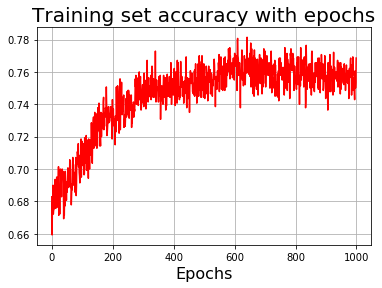

In [44]:
hist=run_NN(nn_model,X_train,y_train,verbosity=0,batch_size=16,
            num_epochs=1000,plot_loss=True)

In [45]:
score=test_NN(hist,X_val,y_val)
print("1-layer NN (using backpropagation) accuracy: ",score)

1-layer NN (using backpropagation) accuracy:  0.813333334128062


### Run 2-layer model with more neurons

In [46]:
nn_model2=make_2layer_NN(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.2,learning_rate=0.0001,
                      neuron_layer_1=10,neuron_layer_2=5,optimizer='Adam')

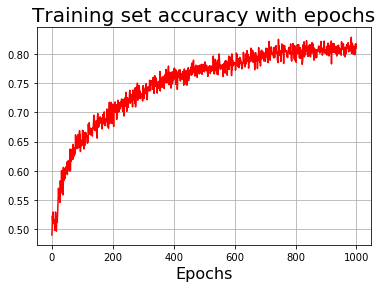

In [48]:
hist2=run_NN(nn_model2,X_train,y_train,verbosity=0,batch_size=16,
            num_epochs=1000,plot_loss=True)

In [50]:
score=test_NN(hist2,X_val,y_val)
print("2-layer NN with more neurons per layer (using backpropagation) accuracy: ",score)

2-layer NN with more neurons per layer (using backpropagation) accuracy:  0.8566666674613953
